<h1>SVM_ECC_ENSO_v3.0</h1>
<div>by Oscar Amarilla</div>

<p>This notebook orchestrates each step of an academic project that consists of applying a machine learning algorithm to the topologycal data analysys (TDA) of the mean sea surface temperature (SST) of a region of the central tropical Pacific.</p>

<h3>Importing modules, packages and data needed for the code</h3>

In [1]:
import numpy as np
import pandas as pd
from src import config
from src.extract import sst_fields, monthly_34_sst_avg 
from src.transform_and_load import TDA_process,ONI
from src.plots import *
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

<h3>Extracting process</h3>
<p>The project needs two data, the first will be extracted from a netCDF file that contains the mean monthly SST from the period 1950-2021 from the region of interest defined by the coordinates (160ºE-270ºE,10ºN-10ºS), and the second is a csv file that contains data about the mean monthly SST of the Niño 3.4 region (170ºO-120ºO,5ºN-5ºS) of the same period of time.</p>
</br>
<p>The netCDF file containing the SST temperature can be adquired in the <a href='https://www.psl.noaa.gov/data/gridded/data.cobe.html'>Pysical Sciences Laboratory of the NOAA</a> and the data about the Niño 3.4 SST can be reached in the <a href='https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'>Climate Prediction Center</a> of the same institution.</p>

In [2]:
sst = sst_fields(config.INPUT_DIR,config.FILES().nc_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: COBE Sea Surface Temperature Analysis
    history: created June 2011 at ESRL/PSD using the grib data from JRA.
    platform: Analyses
    original_source: http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_catalog?projectname=NEAR-GOOS
    Conventions: CF-1.2
    institution: NOAA ESRL/PSD
    comment: recent values (w/i last year) may change as dataset is updated. It is a monitoring dataset.
    dataset_title: COBE Sea Surface Temperature
    References: https://www.psl.noaa.gov/data/gridded/data.cobe.html
    dimensions(sizes): lon(360), lat(180), time(1577)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 sst(time, lat, lon)
    groups: 


<p>The following plot shows, in red, the region of the central tropical Pacific that is of interest for this project.</p>

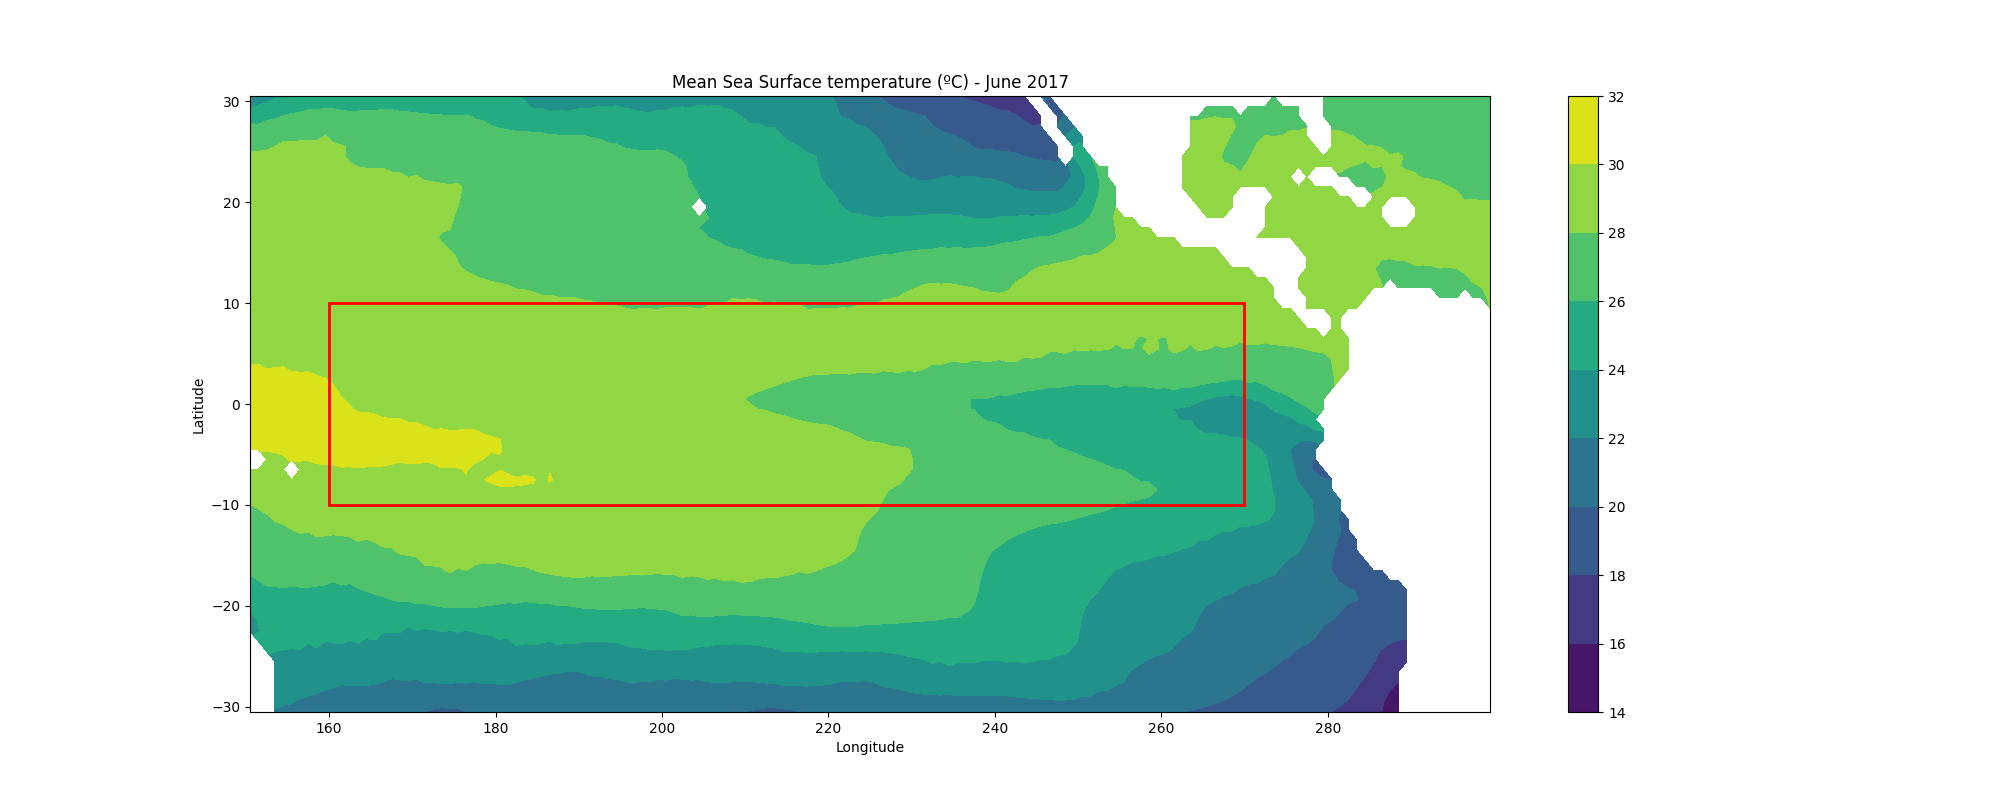

In [3]:
Image(filename='outputs/june_17.png')

In [4]:
sst_34 = monthly_34_sst_avg(config.INPUT_DIR,config.FILES().csv_file)

In [5]:
sst_34.head()

,Year,Month,Anomaly (ºC)
0,1950,1,-1.62
1,1950,2,-1.32
2,1950,3,-1.07
3,1950,4,-1.11
4,1950,5,-1.37


<h3>Transformation and loading process</h3>
<p>The TDA_process function performs two task:</p>
<ul>
    <li>The <a href='https://poe.com/s/CVt9fTJ73PXluwaeLO97'>sub-level set filtration</a> of each SST field</li>
    <li>The computation of the <a href='https://poe.com/s/GNsohOeUu8ZlKgfr4raI'>Euler characteristic curves</a> of each filtration</li>
</ul>

In [6]:
database = TDA_process(sst)

database.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
1950_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Then, the ONI function takes the sst_34 dataframe and computes the <a href='https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index'>Oceanic Niño Index (ONI)</a> to then place the ouputs in the <em>enso_info</em> dataframe as a new column.</p>
<p>Specifically, the ONI function assigns a numerical label to each row of the dataframe depending on the ESNO phase that corresponds to that particular month. These labels are:</p>
<ul>
    <li>Niña: 0</li>
    <li>Normal conditions: 1</li>
    <li>Niño: 2</li>
</ul>

In [7]:
enso_info = ONI(sst_34)

enso_info.head()

,Year,Month,Anomaly (ºC),Phase
0,1950,1,-1.62,0
1,1950,2,-1.32,0
2,1950,3,-1.07,0
3,1950,4,-1.11,0
4,1950,5,-1.37,0


<h3>Reshaping the distribution of phases</h3>

<p>A histogram of the different ENSO phases shows that the data is unbalanced with respect to the normal conditions, which occurs arround 1.5 times more than the other events.</p>

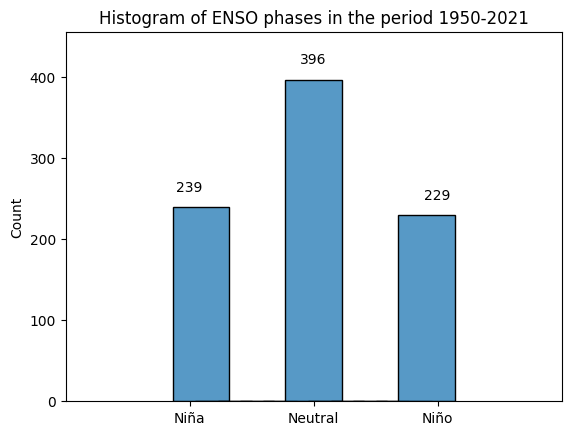

In [8]:
first_histo(enso_info)

<p>In order to balance the dataset, what is proposed is to cluster the dataset into five categories:</p>
<ul>
    <li>ln: Low negative</li>
    <li>un: Upper negative</li>
    <li>c: Center</li>
    <li>lp: Low positive</li>
    <li>up: Upper positive</li>
</ul>

In [9]:
neutral_index = enso_info.index[enso_info['Phase']==1].tolist()
enso_info["cat"]=pd.cut(enso_info['Anomaly (ºC)'][neutral_index], bins=5, labels=["ln","un","c","lp","up"])

<p>Now that the distribution is known, the neutral phases records will be downscaled from 396 to 233, which is the average number of extreme events and it represents around the 59% of the months with normal conditions.</p>

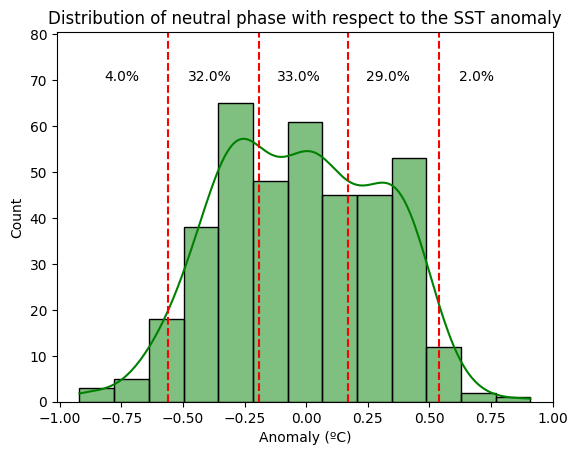

In [10]:
neutro_distribution(enso_info,neutral_index)

In [11]:
lst=enso_info["cat"][neutral_index]

In [12]:
neutro_index,X_test,y_train,y_test=train_test_split(neutral_index,lst, test_size=0.41, random_state=0, shuffle=None, stratify=lst)

In [13]:
enso_info_strat = enso_info.drop(index=X_test)
indexes = database.iloc[X_test].index
database_strat = database.drop(index=indexes)
neutral_index_strat = enso_info_strat.index[enso_info_strat['Phase']==1].tolist()

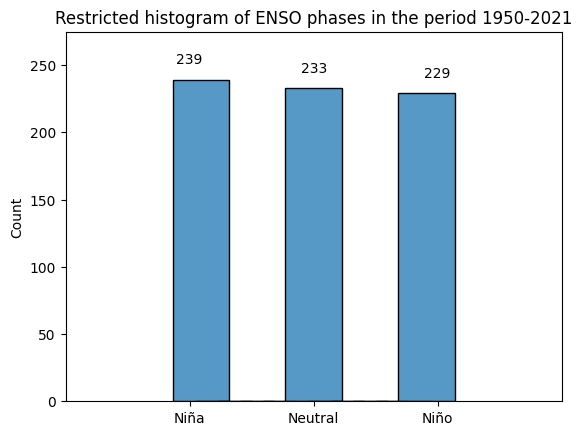

In [14]:
first_histo(enso_info_strat,kind='restricted')

<p>In the plot can be seen that volume of data is lower but the distribution of events has just merely changed.</p>

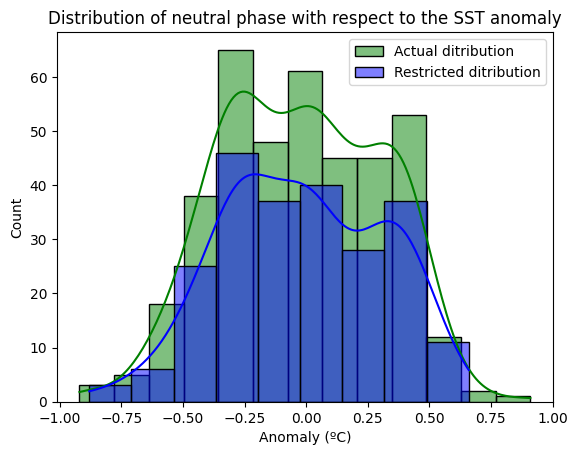

In [15]:
compared_histo(enso_info, enso_info_strat, neutral_index, neutral_index_strat)

<h2>Comparing the ECCs of the Niña and Niño phases</h2>
<p>The first step is to verify how efficient the classifier is discriminating the topological descriptors of opposite events (Niña and Niño phases).</p>
<br>
<p>These first blocks of code set the configuration of the model. Here two model will be proposed, one polinomial and other non-polinomial.</p>

In [16]:
model = svm.SVC()

In [17]:
scaler = StandardScaler()

In [18]:
poly_param_grid = dict(
    kernel = ['poly'], 
    degree=[1,2,3,4,5], 
    C=[1,2,3,4,5])

In [19]:
non_poly_param_grid = dict(
    kernel = ['rbf', 'sigmoid'],
    C=[1,2,3,4,5],
    gamma=['scale', 'auto'] + list(np.logspace(-3, 0, 4)))

In [86]:
cv = KFold(n_splits=20, random_state=2, shuffle=True)

In [87]:
poly_grid = GridSearchCV(estimator=model, param_grid=poly_param_grid, n_jobs=-2, cv=cv)

In [88]:
non_poly_grid = GridSearchCV(estimator=model, param_grid=non_poly_param_grid, n_jobs=-2, cv=cv)

<h3>Preparing the data</h3>

In [23]:
mask = list((enso_info['Phase']==0) | (enso_info['Phase']==2))

LN_EN_database = database[mask]

labels = enso_info[mask]['Phase']

In [24]:
train_X, test_X, train_Y, test_Y = train_test_split(LN_EN_database, labels, test_size=40, random_state=0, shuffle=True)

In [25]:
train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

<h3>Searching the best polynomical model</h3>

In [26]:
final_model = poly_grid.fit(train_X, train_Y)

In [27]:
# summarize results
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.876587 with the following hyperparameters {'C': 5, 'degree': 3, 'kernel': 'poly'}


In [28]:
y_hat = final_model.predict(test_X)

In [29]:
print(classification_report(y_hat, test_Y))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           2       0.86      0.82      0.84        22

    accuracy                           0.82        40
   macro avg       0.82      0.83      0.82        40
weighted avg       0.83      0.82      0.83        40



<h3>Searching the best non-polynomical model</h3>

In [30]:
final_model = non_poly_grid.fit(train_X, train_Y)

In [31]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.909193 with the following hyperparameters {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}


In [32]:
y_hat = final_model.predict(test_X)

In [33]:
print(classification_report(y_hat, test_Y))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           2       0.90      0.86      0.88        22

    accuracy                           0.88        40
   macro avg       0.87      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40



<h2>Developing a model for classify the ENSO phases</h2>
<p>Now the task is to make a model that can distinguish between the three phases of the ENSO phenomena. Again, a polinomial and non-polinomial models are proposed.</p>

<h3>Preparing the data.</h3>

In [89]:
train_X, test_X, train_Y, test_Y = train_test_split(database_strat, enso_info_strat['Phase'], test_size=.3, random_state=3, shuffle=True)

In [90]:
train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

<h3>Searching the best polynomical model</h3>

In [91]:
model = svm.SVC(decision_function_shape='ovo')

In [92]:
final_model = poly_grid.fit(train_X, train_Y)

In [93]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.574083 with the following hyperparameters {'C': 4, 'degree': 3, 'kernel': 'poly'}


In [94]:
y_hat = final_model.predict(test_X)

In [95]:
print(classification_report(y_hat, test_Y))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        60
           1       0.58      0.55      0.57        74
           2       0.75      0.66      0.70        77

    accuracy                           0.65       211
   macro avg       0.66      0.66      0.66       211
weighted avg       0.66      0.65      0.65       211



<h3>Searching the best non-polynomical model</h3>

In [96]:
model = svm.SVC(decision_function_shape='ovr')

In [97]:
final_model = non_poly_grid.fit(train_X, train_Y)

In [98]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.597917 with the following hyperparameters {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}


In [99]:
y_hat = final_model.predict(test_X)

In [100]:
print(classification_report(y_hat, test_Y))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        79
           1       0.52      0.61      0.56        61
           2       0.75      0.72      0.73        71

    accuracy                           0.69       211
   macro avg       0.69      0.68      0.68       211
weighted avg       0.70      0.69      0.69       211

